## Test to show the map in image form 


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
ds = rasterio.open("_agri1.tif")

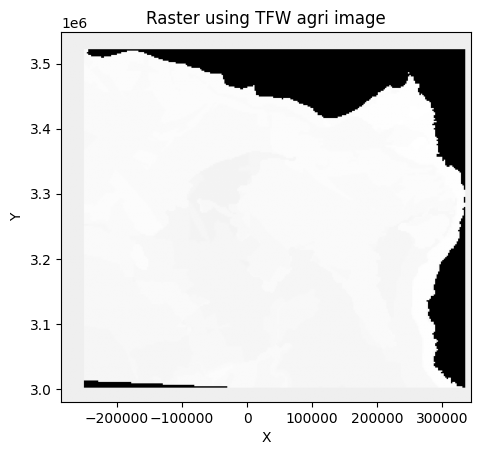

In [3]:
img = ds.read(1)

extent = (
    ds.bounds.left,
    ds.bounds.right,
    ds.bounds.bottom,
    ds.bounds.top
)

plt.imshow(img, cmap="gray", extent=extent)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raster using TFW agri image")
plt.show()

# start of the project 
**Land Use Suitability Integration Using AI-Based Priority Rules
This script integrates multiple land use suitability maps into a single
composite map based on hierarchical planning priorities.**

In [4]:
# File names for each suitability map
FILES = {
    'agriculture': '_agri1.tif',
    'industry': 'ind.tif',
    'commerce': 'trad.tif',
    'mask': 'mask.tif',
    'housing':"residential.tif"
}


# Activity codes for the final map
ACTIVITY_CODES = {
    1: 'Agriculture',
    2: 'Industry',
    3: 'Commerce',
    4: 'Residential',
    0: 'Restricted Area',
    -1: 'Excluded Area',
    -99: 'Error/Unclassified'
}

# Colors for visualization
COLORS = {
    1: '#4CAF50',    # Green for Agriculture
    2: '#FF9800',    # Orange for Industry
    3: '#2196F3',    # Blue for Commerce
    4: '#E91E63',    # Pink for Residential
    0: '#795548',    # Brown for Restricted
    -1: '#9E9E9E',   # Gray for Excluded
    -99: '#000000'   # Black for Error
}

## DATA LOADING AND PREPARATION

In [5]:
def load_and_prepare_data():
    """
    Load all raster files and prepare them for processing.
    
    Returns:
        data: Dictionary with processed arrays for each activity
        profiles: Dictionary with raster profiles for saving output
    """
       
    print("Loading data files...")
    
    data = {}
    profiles = {}
    
    for activity_name, file_path in FILES.items():
        try:
            with rasterio.open(file_path) as src:
                # Read the raster data (first band)
                layer_data = src.read(1)
                
                # Save profile for later use when saving results
                profiles[activity_name] = src.profile
                
                # Special handling for agriculture data (has negative values)
                if activity_name == 'agriculture':
                    print(f"  Processing {activity_name} data...")
                    
                    # Replace negative values with minimum positive value
                    if np.any(layer_data > 0):
                        min_positive = np.min(layer_data[layer_data > 0])
                    else:
                        min_positive = 1
                    
                    # Count negative values before replacement
                    negative_count = np.sum(layer_data < 0)
                    layer_data[layer_data < 0] = min_positive
                    
                    if negative_count > 0:
                        print(f"    Fixed {negative_count} negative values")
                
                # Convert to appropriate data type
                layer_data = layer_data.astype(np.int8)
                
                # Normalize suitability values to 0-9 range (except mask)
                if activity_name != 'mask':
                    # Clip values to ensure they're within 0-9 range
                    layer_data = np.clip(layer_data, 0, 9)
                
                data[activity_name] = layer_data
                print(f"  [OK] {activity_name}: Shape {layer_data.shape}, "
                      f"Range {np.min(layer_data)}-{np.max(layer_data)}")
                
        except Exception as error:
            print(f"  [ERROR] Failed to read {file_path}: {error}")
            return None, None
    
    return data, profiles



## AI PRIORITY INTEGRATION ALGORITHM

In [6]:
def apply_priority_integration(data):
    """
    Apply hierarchical priority rules to integrate suitability maps.
    
    The priority rules follow the hierarchical order specified in the document.
    
    Args:
        data: Dictionary containing arrays for each activity
        
    Returns:
        result: Integrated land use map with activity codes
    """
    print("\nApplying AI priority integration algorithm...")
    # ===============================
# CREATE SYNTHETIC RESIDENTIAL LAYER
# ===============================

    print("\nCreating synthetic Residential suitability layer...")
    
    # Extract data arrays
    agriculture = data['agriculture']
    industry = data['industry']
    commerce = data['commerce']
    housing = data['housing']
    
    mask = data['mask']
    
    # Initialize result array with error code
    result = np.full(agriculture.shape, -99, dtype=np.int8)
    
    # Get array dimensions
    rows, cols = agriculture.shape
    total_cells = rows * cols
    
    print(f"  Processing {total_cells:,} cells...")
    
    # First, apply the mask: set excluded areas (mask=0) to -1
    result[mask == 0] = -1  # Excluded areas
    
    # Define priority rules according to the document
    # Format: ((activity_name, [allowed_values]), result_code)
    priority_rules = [
        (('agriculture', [9, 8]), 1),    # Rule 1
        (('industry', [9, 8]), 2),       # Rule 2
        (('agriculture', [7, 6]), 1),    # Rule 3
        (('commerce', [9]), 3),          # Rule 4
        (('housing', [9, 8]), 4),        # Rule 5
        (('industry', [7, 6]), 2),       # Rule 6
        (('commerce', [8]), 3),          # Rule 7
        (('housing', [7, 6]), 4),        # Rule 8
        (('agriculture', [5]), 1),       # Rule 9
        (('industry', [5]), 2),          # Rule 10
        (('commerce', [5]), 3),          # Rule 11
        (('housing', [5]), 4)            # Rule 12
    ]
    
    # Find all cells available for allocation (mask == 1)
    available_rows, available_cols = np.where(mask == 1)
    num_available = len(available_rows)
    
    # Process each available cell
    for cell_index in range(num_available):
        row = available_rows[cell_index]
        col = available_cols[cell_index]
        
        # Get suitability values for this cell
        cell_values = {
            'agriculture': agriculture[row, col],
            'industry': industry[row, col],
            'commerce': commerce[row, col],
            'housing': housing[row, col]
        }
        
        # Apply priority rules in order
        assigned = False
        for (activity, allowed_values), code in priority_rules:
            if cell_values[activity] in allowed_values:
                result[row, col] = code
                assigned = True
                break
        
        # If no rule matched
        if not assigned:
            # If all values are below 5, mark as restricted
            if all(value < 5 for value in cell_values.values()):
                result[row, col] = 0  # Restricted area
            else:
                result[row, col] = -99  # Error/unexpected case
    
    print("  [OK] Integration completed")
    return result



## SAVE RESULTS

In [7]:
def save_integrated_map(result, profile, output_file='integrated_land_use.tif'):
    """
    Save the integrated land use map as a GeoTIFF file.
    
    Args:
        result: Integrated land use array
        profile: Raster profile for georeferencing
        output_file: Name of the output file
    """
    print(f"\nSaving integrated map to {output_file}...")
    
    # Update profile for output
    profile.update(
        dtype=rasterio.int8,
        count=1,
        nodata=-99,
        compress='lzw'  # Use compression to reduce file size
    )
    
    # Write result to file
    with rasterio.open(output_file, 'w', **profile) as destination:
        destination.write(result.astype(np.int8), 1)
    
    print(f"  [OK] Map saved successfully")



## VISUALIZATION

In [8]:
def create_visualizations(data, result):
    """
    Create visualization plots of input maps and final result.
    
    Args:
        data: Dictionary with input data arrays
        result: Integrated land use array
    """
    print("\nCreating visualization plots...")
    
    # Create figure with 2x3 subplots
    figure, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Titles and corresponding data keys for input maps
    input_titles = ['Agriculture', 'Industry', 'Commerce', 'Residential', 'Mask']
    input_keys = ['agriculture', 'industry', 'commerce', 'housing', 'mask']
    
    # Plot each input map
    for index, (title, key) in enumerate(zip(input_titles, input_keys)):
        axis = axes[index // 3, index % 3]
        
        if key == 'mask':
            # Binary mask plot
            image = axis.imshow(data[key], cmap='binary')
            axis.set_title(f'{title} (0=Excluded, 1=Available)')
        else:
            # Suitability map plot (0-9 scale)
            image = axis.imshow(data[key], cmap='viridis', vmin=0, vmax=9)
            axis.set_title(title)
        
        # Add colorbar
        plt.colorbar(image, ax=axis)
        axis.axis('off')
    
    # Plot the integrated result
    axis = axes[1, 2]
    
    # Create custom colormap for activities
    color_list = [COLORS[code] for code in [1, 2, 3, 4, 0, -1, -99]]
    custom_colormap = ListedColormap(color_list)
    
    # Display result with custom colormap
    image = axis.imshow(result, cmap=custom_colormap, vmin=-1, vmax=5)
    axis.set_title('Integrated Land Use Map')
    axis.axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    
    legend_items = [
        Patch(facecolor=COLORS[1], label='Agriculture'),
        Patch(facecolor=COLORS[2], label='Industry'),
        Patch(facecolor=COLORS[3], label='Commerce'),
        Patch(facecolor=COLORS[4], label='Residential'),
        Patch(facecolor=COLORS[0], label='Restricted'),
        Patch(facecolor=COLORS[-1], label='Excluded'),
        Patch(facecolor=COLORS[-99], label='Error'),
    ]
    
    axis.legend(handles=legend_items, 
                bbox_to_anchor=(1.05, 1), 
                loc='upper left',
                fontsize=10)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('land_use_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("  [OK] Visualization saved as 'land_use_visualization.png'")

In [9]:
def generate_summary_report(result):
    """
    Generate a summary report of the integration results.
    
    Args:
        result: Integrated land use array
    """
    print("\n" + "=" * 50)
    print("INTEGRATION RESULTS SUMMARY")
    print("=" * 50)
    
    total_cells = result.size
    
    # Count cells for each activity code
    unique_codes, cell_counts = np.unique(result, return_counts=True)
    
    # Print statistics for each activity
    for code, count in zip(unique_codes, cell_counts):
        percentage = (count / total_cells) * 100
        activity_name = ACTIVITY_CODES.get(code, f'Unknown ({code})')
        
        print(f"{activity_name:20} {count:10,} cells ({percentage:6.2f}%)")
    
    # Additional summary statistics
    print("\n" + "-" * 50)
    print("ADDITIONAL STATISTICS:")
    print(f"Total cells processed: {total_cells:,}")
    
    available_cells = np.sum(result > -99)
    print(f"Cells available for allocation: {available_cells:,}")
    
    restricted_cells = np.sum(result == 0)
    print(f"Restricted development areas: {restricted_cells:,}")
    
    excluded_cells = np.sum(result == -1)
    print(f"Excluded areas (existing uses): {excluded_cells:,}")
    
    error_cells = np.sum(result == -99)
    print(f"Error/unclassified cells: {error_cells:,}")



In [10]:
# ====================== MAIN EXECUTION ======================

def main():
    """
    Main function to execute the land use integration process.
    """
    print("=" * 60)
    print("LAND USE SUITABILITY INTEGRATION USING AI PRIORITY RULES")
    print("=" * 60)
    
    # Step 1: Load and prepare data
    print("\nSTEP 1: Loading input data...")
    input_data, raster_profiles = load_and_prepare_data()
    
    if input_data is None:
        print("[ERROR] Failed to load input data. Please check file paths.")
        return

        
        # Fix array sizes before integration
    print("\nFixing array sizes to match...")

     # Get the shape of agriculture (or any reference layer)
    reference_shape = input_data['agriculture'].shape
    print(f"Reference shape (agriculture): {reference_shape}")

     # Resize all other layers to match agriculture
    for key in input_data.keys():
        if input_data[key].shape != reference_shape:
            print(f"  Resizing {key} from {input_data[key].shape} to {reference_shape}")
        # Simple resizing - crop or pad as needed
        # Option 1: Crop to fit
            current = input_data[key]
            rows, cols = current.shape
            target_rows, target_cols = reference_shape
        
            if rows > target_rows or cols > target_cols:
            # Crop
                cropped = current[:target_rows, :target_cols]
                input_data[key] = cropped
            else:
            # Pad with zeros
                padded = np.zeros(reference_shape, dtype=current.dtype)
                padded[:rows, :cols] = current
                input_data[key] = padded

    print("\nFinal array sizes:")
    for key, arr in input_data.items():
        print(f"  {key}: {arr.shape}")
    
    # Step 2: Apply AI priority integration
    print("\nSTEP 2: Applying priority-based integration...")
    integrated_map = apply_priority_integration(input_data)
    
    # Step 3: Save the integrated map
    print("\nSTEP 3: Saving results...")
    save_integrated_map(integrated_map, raster_profiles['agriculture'])
    
    # Step 4: Create visualizations
    print("\nSTEP 4: Creating visualizations...")
    create_visualizations(input_data, integrated_map)
    
    # Step 5: Generate report
    print("\nSTEP 5: Generating summary report...")
    generate_summary_report(integrated_map)
    
    # Final message
    print("\n" + "=" * 60)
    print("PROCESS COMPLETED SUCCESSFULLY")
    print("=" * 60)
    print("\nOutput files generated:")
    print("  1. integrated_land_use.tif - Final integrated map (GeoTIFF)")
    print("  2. land_use_visualization.png - Visualization of results")
    print("\nThe integrated map uses the following codes:")
    print("  1 = Agriculture")
    print("  2 = Industry")
    print("  3 = Commerce")
    print("  4 = Residential")
    print("  0 = Restricted development area")
    print(" -1 = Excluded area (existing land use)")
    print("-99 = Error or unclassified")


LAND USE SUITABILITY INTEGRATION USING AI PRIORITY RULES

STEP 1: Loading input data...
Loading data files...
  Processing agriculture data...
    Fixed 9797 negative values
  [OK] agriculture: Shape (258, 286), Range 0-9
  [OK] industry: Shape (228, 199), Range 0-9
  [OK] commerce: Shape (257, 265), Range 0-9
  [OK] mask: Shape (273, 312), Range 0-1
  [OK] housing: Shape (258, 286), Range 0-9

Fixing array sizes to match...
Reference shape (agriculture): (258, 286)
  Resizing industry from (228, 199) to (258, 286)
  Resizing commerce from (257, 265) to (258, 286)
  Resizing mask from (273, 312) to (258, 286)

Final array sizes:
  agriculture: (258, 286)
  industry: (258, 286)
  commerce: (258, 286)
  mask: (258, 286)
  housing: (258, 286)

STEP 2: Applying priority-based integration...

Applying AI priority integration algorithm...

Creating synthetic Residential suitability layer...
  Processing 73,788 cells...
  [OK] Integration completed

STEP 3: Saving results...

Saving integrate

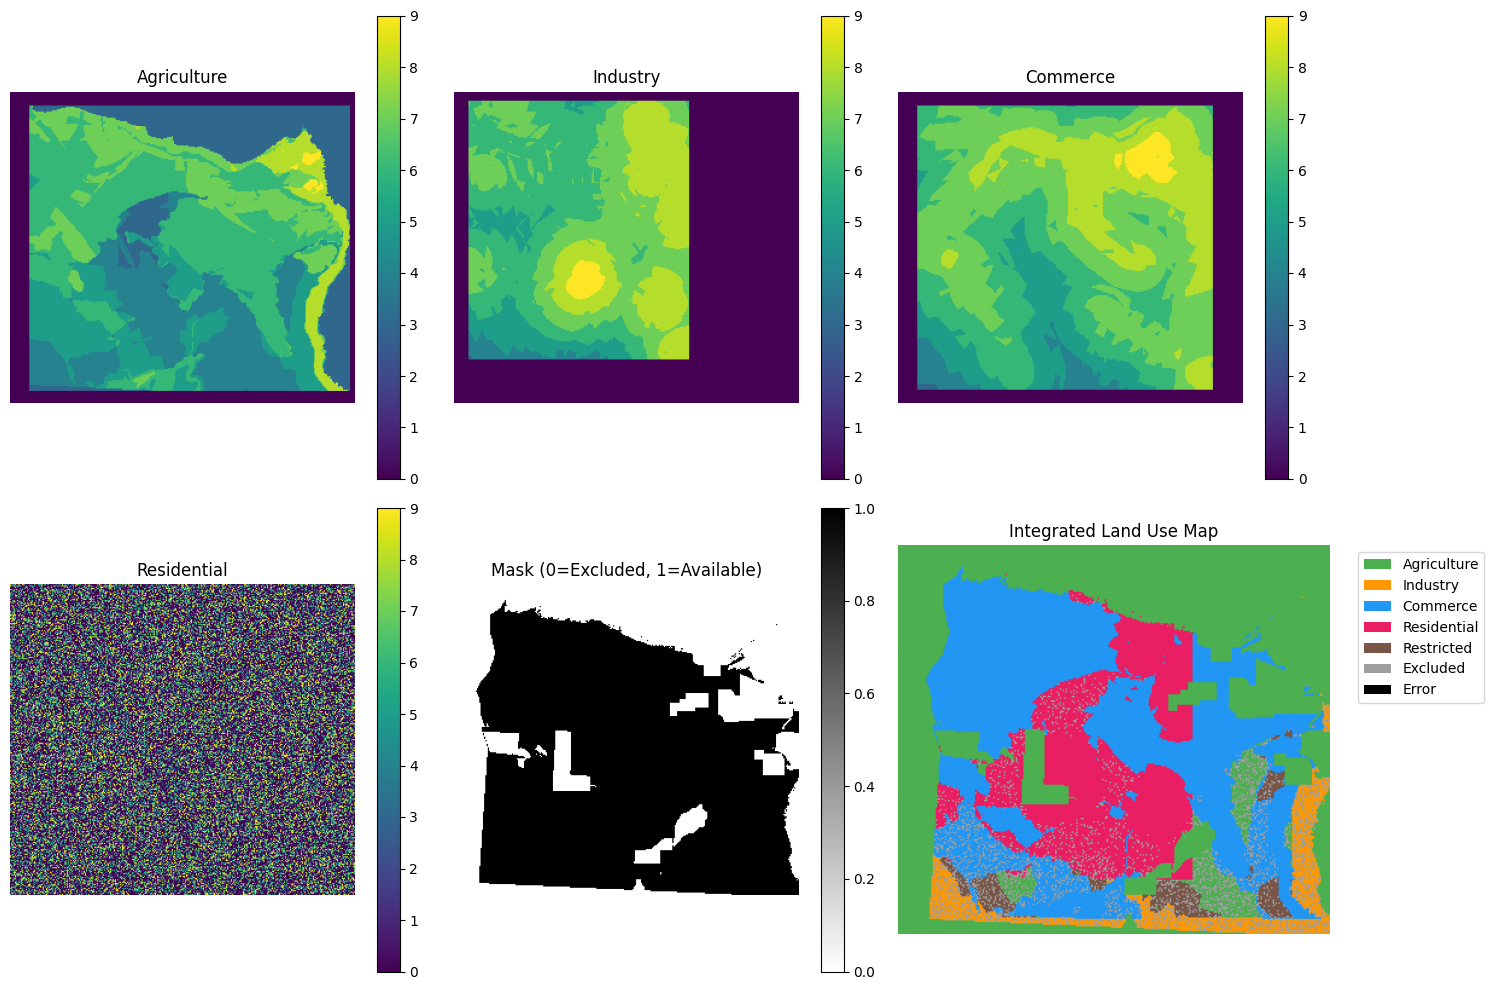

  [OK] Visualization saved as 'land_use_visualization.png'

STEP 5: Generating summary report...

INTEGRATION RESULTS SUMMARY
Error/Unclassified        1,714 cells (  2.32%)
Excluded Area            26,711 cells ( 36.20%)
Restricted Area           2,938 cells (  3.98%)
Agriculture              23,858 cells ( 32.33%)
Industry                 12,380 cells ( 16.78%)
Commerce                  1,571 cells (  2.13%)
Residential               4,616 cells (  6.26%)

--------------------------------------------------
ADDITIONAL STATISTICS:
Total cells processed: 73,788
Cells available for allocation: 72,074
Restricted development areas: 2,938
Excluded areas (existing uses): 26,711
Error/unclassified cells: 1,714

PROCESS COMPLETED SUCCESSFULLY

Output files generated:
  1. integrated_land_use.tif - Final integrated map (GeoTIFF)
  2. land_use_visualization.png - Visualization of results

The integrated map uses the following codes:
  1 = Agriculture
  2 = Industry
  3 = Commerce
  4 = Residenti

In [11]:
main()